<a href="https://colab.research.google.com/github/Threadstone15/3D-Unet/blob/main/3D_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
!pip install classification-models-3D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 2.9 MB/s eta 0:00:00


In [3]:
!pip install efficientnet-3D

In [4]:
!pip install segmentation-models-3D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires keras>=3.5.0, but you have keras 3.3.3 which is incompatible.


In [5]:
!pip install patchify

In [6]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.18.0
3.3.3


In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
import segmentation_models_3D as sm

Segmentation Models: using `keras` framework.


In [9]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [10]:
from google.colab import drive
drive.mount('/content/drive')
image = io.imread('/content/drive/MyDrive/ML Data/3D-Unet-Demo/sandstone_data_for_ML/data_for_3D_Unet/train_images_256_256_256.tif')
img_patches = patchify(image, (64, 64, 64), step=64)

Mounted at /content/drive


In [11]:
mask = io.imread('/content/drive/MyDrive/ML Data/3D-Unet-Demo/sandstone_data_for_ML/data_for_3D_Unet/train_masks_256_256_256.tif')
mask_patches = patchify(mask, (64, 64, 64), step=64)

In [12]:
print(image.shape)
print(img_patches.shape)
print(mask.shape)
print(mask_patches.shape)

(256, 256, 256)
(4, 4, 4, 64, 64, 64)
(256, 256, 256)
(4, 4, 4, 64, 64, 64)


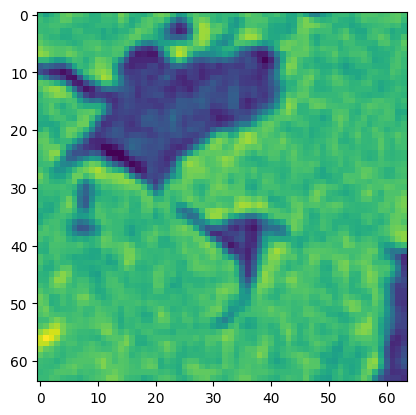

In [13]:
plt.imshow(img_patches[1,2,3,:,:,20])


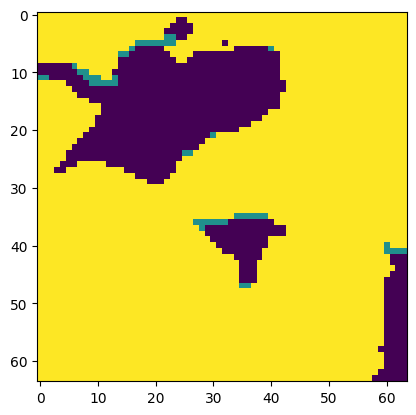

In [14]:
plt.imshow(mask_patches[1,2,3,:,:,20])

In [15]:
input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))
print(input_img.shape)
print(input_mask.shape)

(64, 64, 64, 64)
(64, 64, 64, 64)


In [16]:
n_classes = 4

In [17]:
train_img = np.stack((input_img,)*3, axis=-1)
train_img.shape

(64, 64, 64, 64, 3)

In [18]:
train_mask = np.expand_dims(input_mask, axis=4)
train_mask.shape

(64, 64, 64, 64, 1)

In [19]:
train_mask_cat = to_categorical(train_mask, num_classes=n_classes)
train_mask_cat.shape

(64, 64, 64, 64, 4)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 42)

In [21]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [22]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

In [23]:
encoder_weights = 'imagenet'
BACKBONE = 'resnet50'
activation = 'softmax'
patch_size = 64
n_classes = 4
channels = 3

In [24]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [25]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [26]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [27]:
preprocess_input = sm.get_preprocessing(BACKBONE)
print(preprocess_input)

<function preprocess_input at 0x7d19a3394ea0>


In [28]:
X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

In [29]:
model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(patch_size,patch_size,patch_size,channels), activation=activation, encoder_weights=encoder_weights)

185458584/185458584 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [30]:
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, 64, 64, 64, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_data                   │ (None, 64, 64, 64, 3)  │              9 │ data[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding3d            │ (None, 70, 70, 70, 3)  │              0 │ bn_data[0][0]          │
│ (ZeroPadding3D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv3D)            │ (None, 32, 32, 32, 64) │         65,856 │ zero_padding3d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, 32, 32, 32, 64) │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (Activation)        │ (None, 32, 32, 32, 64) │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding3d_1          │ (None, 34, 34, 34, 64) │              0 │ relu0[0][0]            │
│ (ZeroPadding3D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling0 (MaxPooling3D)   │ (None, 16, 16, 16, 64) │              0 │ zero_padding3d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn1          │ (None, 16, 16, 16, 64) │            256 │ pooling0[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu1        │ (None, 16, 16, 16, 64) │              0 │ stage1_unit1_bn1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv1        │ (None, 16, 16, 16, 64) │          4,096 │ stage1_unit1_relu1[0]… │
│ (Conv3D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn2          │ (None, 16, 16, 16, 64) │            256 │ stage1_unit1_conv1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu2        │ (None, 16, 16, 16, 64) │              0 │ stage1_unit1_bn2[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding3d_2          │ (None, 18, 18, 18, 64) │              0 │ stage1_unit1_relu2[0]… │
│ (ZeroPadding3D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv2        │ (None, 16, 16, 16, 64) │        110,592 │ zero_padding3d_2[0][0] │
│ (Conv3D)             

 Total params: 73,275,533 (279.52 MB)

 Trainable params: 73,227,975 (279.34 MB)

 Non-trainable params: 47,558 (185.77 KB)

None


In [31]:
#history = model.fit(X_train_prep, y_train, batch_size=8, epochs=100, verbose=1, validation_data=(X_test_prep, y_test))

In [32]:
#model.save('/content/drive/MyDrive/ML Data/3D-Unet-Demo/sandstone_data_for_ML/data_for_3D_Unet/3D_Unet_model_vgg16_100epo.h5')

In [35]:
from keras.models import load_model
my_model = load_model('/content/drive/MyDrive/ML Data/3D-Unet-Demo/sandstone_data_for_ML/data_for_3D_Unet/3D_Unet_model_vgg16_100epo.h5', compile=False)

In [44]:
y_pred = my_model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [45]:
print(y_pred_argmax.shape)
print(y_test_argmax.shape)
print(np.unique(y_pred_argmax))

(7, 64, 64, 64)
(7, 64, 64, 64)
[0 1 2 3]


In [51]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

In [54]:
test_img_input = np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)
test_pred1 = my_model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]
print(test_img_input.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(1, 64, 64, 64, 3)


In [55]:
ground_truth_argmax = np.argmax(ground_truth, axis=3)
print(test_img.shape)

(64, 64, 64, 3)


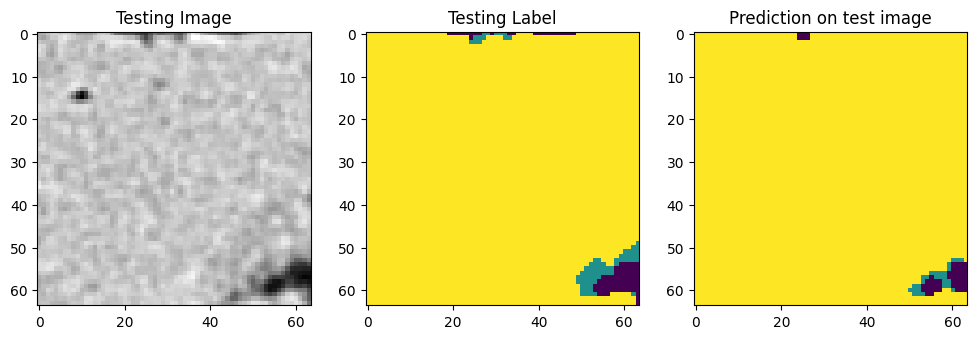

In [58]:
slice=25
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0],cmap='grey')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1[slice,:,:])
plt.show()

In [60]:
large_image = io.imread('/content/drive/MyDrive/ML Data/3D-Unet-Demo/sandstone_data_for_ML/data_for_3D_Unet/448_images_512x512.tif')

In [61]:
patches = patchify(large_image, (64, 64, 64), step=64)
print(large_image.shape)
print(patches.shape)

(448, 512, 512)
(7, 8, 8, 64, 64, 64)


In [62]:
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      single_patch = patches[i,j,k,:,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
      single_patch_pred = my_model.predict(single_patch_3ch_input)
      single_patch_pred_argmax = np.argmax(single_patch_pred, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_pred_argmax)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

In [63]:
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(448, 64, 64, 64)


In [64]:
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patches.shape[2], patches.shape[3], patches.shape[4], patches.shape[5]))
print(predicted_patches_reshaped.shape)

(7, 8, 8, 64, 64, 64)


In [65]:
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
print(reconstructed_image.shape)

(448, 512, 512)


In [66]:
print(reconstructed_image.dtype)

int64


In [67]:
reconstructed_image = reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

uint8


In [68]:
from tifffile import imsave
imsave('/content/drive/MyDrive/ML Data/3D-Unet-Demo/sandstone_data_for_ML/data_for_3D_Unet/segmented.tif',reconstructed_image)

<ipython-input-68-19c83457e1fb>:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('/content/drive/MyDrive/ML Data/3D-Unet-Demo/sandstone_data_for_ML/data_for_3D_Unet/segmented.tif',reconstructed_image)


In [87]:
import numpy as np

num_segment = 4
segm0 = (reconstructed_image == 0)
segm1 = (reconstructed_image == 1)
segm2 = (reconstructed_image == 2)
segm3 = (reconstructed_image == 3)

# Fix: Use 4 channels instead of 3
final = np.empty((reconstructed_image.shape[0], reconstructed_image.shape[1], reconstructed_image.shape[2], 4), dtype=np.float32)

final[:, :, :, 0] = segm0
final[:, :, :, 1] = segm1
final[:, :, :, 2] = segm2
final[:, :, :, 3] = segm3  # Fix: Now 4 channels available



In [74]:
!pip install apeer-ometiff-library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 20.7 MB/s eta 0:00:00


In [75]:
from apeer_ometiff_library import io

In [88]:
final = np.expand_dims(final, axis=0)
#final = np.swapaxes(final, 1, 2)
final = np.swapaxes(final, 2, 4)
final = final.astype(np.uint8)
print("Shape of the segmented volume is: T,Z,C,X,Y",final.shape)
print(final.dtype)

Shape of the segmented volume is: T,Z,C,X,Y (1, 448, 4, 512, 512)
uint8


In [89]:
io.write_ometiff("/content/drive/MyDrive/ML Data/3D-Unet-Demo/sandstone_data_for_ML/data_for_3D_Unet/segmented_multichannel.tif",final)

In [93]:
import tifffile as tiff
import matplotlib.pyplot as plt
from ipywidgets import interact


image_path = "/content/drive/MyDrive/ML Data/3D-Unet-Demo/sandstone_data_for_ML/data_for_3D_Unet/segmented_multichannel.tif"
image = tiff.imread(image_path)


print(f"Image shape: {image.shape}")

p
def view_slice(slice_idx, channel_idx=0, cmap_choice="jet"):
    plt.figure(figsize=(6,6))


    selected_image = image[slice_idx, channel_idx, :, :]


    plt.imshow(selected_image, cmap=cmap_choice)
    plt.title(f"Slice {slice_idx}/{image.shape[0]-1}, Channel {channel_idx}")
    plt.axis("off")
    plt.colorbar()
    plt.show()

interact(view_slice,
         slice_idx=(0, image.shape[0]-1),
         channel_idx=(0, image.shape[1]-1),
         cmap_choice=["jet", "viridis", "plasma", "inferno", "magma", "cividis"]);


Image shape: (448, 4, 512, 512)


interactive(children=(IntSlider(value=223, description='slice_idx', max=447), IntSlider(value=0, description='…

In [94]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact

# Load the 3D multi-channel TIFF image
image_path = "/content/drive/MyDrive/ML Data/3D-Unet-Demo/sandstone_data_for_ML/data_for_3D_Unet/segmented_multichannel.tif"
image = tiff.imread(image_path)

# Check image shape
print(f"Image shape: {image.shape}")  # (448, 4, 512, 512)

# Function to visualize all channels in different colors
def view_multi_channel_slice(slice_idx):
    # Extract the 4 channels from the selected slice
    slice_data = image[slice_idx]  # Shape: (4, 512, 512)

    # Normalize each channel to range [0,1] for proper visualization
    slice_norm = (slice_data - slice_data.min()) / (slice_data.max() - slice_data.min() + 1e-6)

    # Create an RGB overlay: Map 3 channels to RGB, and blend the 4th
    rgb_image = np.zeros((512, 512, 3))  # Empty RGB array

    rgb_image[:, :, 0] = slice_norm[0]  # Red (Channel 0)
    rgb_image[:, :, 1] = slice_norm[1]  # Green (Channel 1)
    rgb_image[:, :, 2] = slice_norm[2]  # Blue (Channel 2)

    # Blend 4th channel as Yellow (Red + Green)
    yellow_overlay = np.stack([slice_norm[3], slice_norm[3], np.zeros_like(slice_norm[3])], axis=-1)
    rgb_image = np.clip(rgb_image + 0.5 * yellow_overlay, 0, 1)  # Blend Yellow channel

    # Display image
    plt.figure(figsize=(6,6))
    plt.imshow(rgb_image)
    plt.title(f"Multi-Channel Visualization - Slice {slice_idx}")
    plt.axis("off")
    plt.show()

# Interactive slice selection
interact(view_multi_channel_slice, slice_idx=(0, image.shape[0]-1));


Image shape: (448, 4, 512, 512)


interactive(children=(IntSlider(value=223, description='slice_idx', max=447), Output()), _dom_classes=('widget…